In [1]:
from scipy.io import loadmat
from scipy import signal
import librosa.display
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import IPython

MAX_IR_LEN = 20000
SR = 96000

(518, 1589)


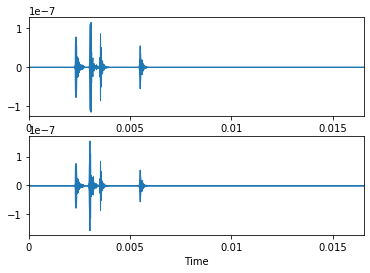

In [3]:
room_path = '/datasets/home/07/907/k1feng/NeuralReverb/dataset/VAST/anechoic.mat'
x = loadmat(room_path)
l_ir     = x['RIR'][0,0][0].T
r_ir     = x['RIR'][0,0][1].T

print(l_ir.shape)
plt.subplot(2, 1, 1)
librosa.display.waveplot(l_ir[0], sr=SR)
plt.subplot(2, 1, 2)
librosa.display.waveplot(r_ir[0], sr=SR)

plt.show()

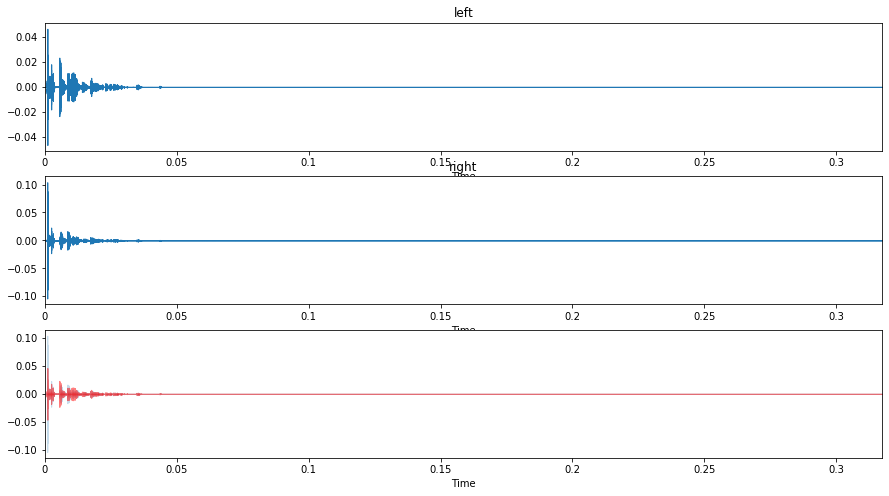

In [4]:
room_path = '/datasets/home/07/907/k1feng/NeuralReverb/dataset/VAST/train/TrainRoom1'
x = loadmat(room_path)
l_ir     = x['RIR'][0,0][0].T
r_ir     = x['RIR'][0,0][1].T
l_ir     = np.pad(l_ir, (0,MAX_IR_LEN), mode='constant', constant_values=0)
r_ir     = np.pad(r_ir, (0,MAX_IR_LEN), mode='constant', constant_values=0)

plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
librosa.display.waveplot(l_ir[0], sr=SR)
plt.title('left')
plt.subplot(3, 1, 2)
librosa.display.waveplot(r_ir[0], sr=SR)
plt.title('right')
plt.subplot(3, 1, 3)
librosa.display.waveplot(r_ir[0], sr=SR, alpha=0.25)
librosa.display.waveplot(l_ir[0], sr=SR, color='r', alpha=0.5)
plt.show()

In [5]:
IPython.display.Audio(l_ir[0], rate=SR)

(33, 1905)
(33, 1905)
(129, 477)
(129, 477)


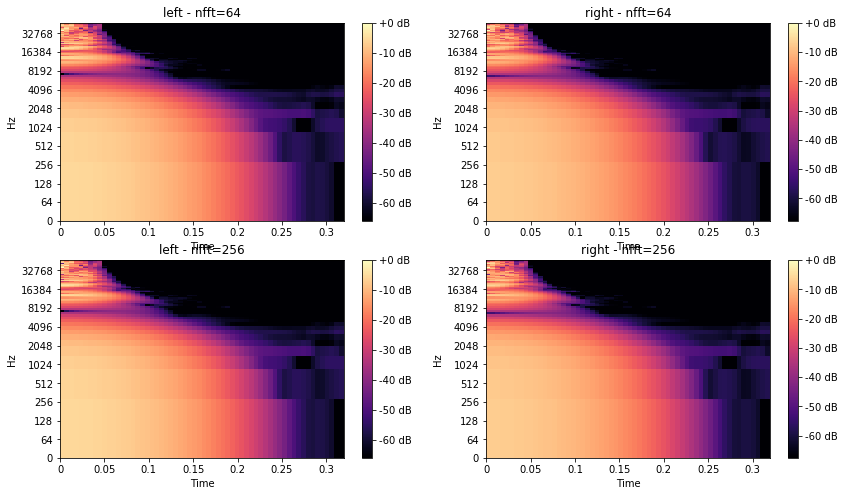

In [6]:
def drawFFT(y, nfft=64):
    fft = librosa.stft(y,hop_length=int(nfft/4), win_length=nfft, n_fft=nfft, center=True)
    print(fft.shape)
    d = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=SR)), ref=np.max)
    librosa.display.specshow(d, sr=SR, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
plt.title('left - nfft=64')
drawFFT(l_ir[0],nfft=64)
plt.subplot(2,2,2)
plt.title('right - nfft=64')
drawFFT(r_ir[0],nfft=64)
plt.subplot(2,2,3)
plt.title('left - nfft=256')
drawFFT(l_ir[0],nfft=256)
plt.subplot(2,2,4)
plt.title('right - nfft=256')
drawFFT(r_ir[0],nfft=256)

In [ ]:
import yaml
from neuralnet.model import SimpleReverberator
from data.data_loader import get_loader
import torch

config = yaml.load(open('config/base_gru.yaml', 'r'), Loader=yaml.SafeLoader)
loader = get_loader(name=config['train_dataset']['name'], 
                datadir = config['train_dataset']['datadir'],
                anechoic_path = config['train_dataset']['anechoic'],
                batch_size = config['train_dataset']['batch_size'], 
                num_workers = config['train_dataset']['num_workers']) 

model = SimpleReverberator(config).to('cuda')

count = 0

for epoch in range(10):
    train_loss = 0
    for y, y_orig in loader:
        model.set_input(y.to('cuda'), y_orig.to('cuda'))
        model.optimize_parameters()
        train_loss += model.loss.item()
    print('Epoch {}, train loss - {}'.format(epoch, train_loss))

Epoch 0, train loss - 59019750050.25
Epoch 1, train loss - 4049468910.40625
Epoch 2, train loss - 1293821666.3671875
Epoch 3, train loss - 558275401.4511719
Epoch 4, train loss - 347577503.86621094
Epoch 5, train loss - 197485858.87109375
Epoch 6, train loss - 174399459.7138672
Epoch 7, train loss - 84772680.70727539


In [ ]:
y_orig = model.y_orig[:,0,:].squeeze(1).cpu().numpy()[0]
y_synth= model.y_synth.view(-1, model.y_synth.size(2)).detach().cpu().numpy()[0]
y_wet  = model.y.view(-1, model.y.size(2)).detach().cpu().numpy()[0]
stft   = librosa.stft(y_synth,hop_length=int(256/4), win_length=256, n_fft=256, center=True)
stft_orig = librosa.stft(y_wet,hop_length=int(256/4), win_length=256, n_fft=256, center=True)


plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.title('left - nfft=64')
drawFFT(y_orig,nfft=256)
plt.subplot(2,1,2)
plt.title('right - nfft=64')
drawFFT(y_wet,nfft=256)

In [ ]:
plt.subplot(3, 1, 1)
librosa.display.waveplot(y_wet, sr=SR)
plt.subplot(3, 1, 2)
librosa.display.waveplot(y_orig, sr=SR)
plt.subplot(3, 1, 3)
librosa.display.waveplot(y_synth, sr=SR)

In [ ]:
IPython.display.Audio(y_synth, rate=SR)